In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Input/faceDetectionModels'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Using haar cascade to detect faces

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [2]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('Input/faceDetectionModels/haarcascade_frontalface_default.xml')

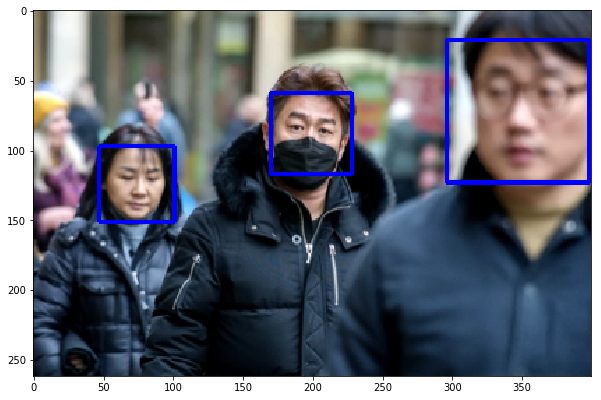

In [3]:
#trying it out on a sample image
img = cv2.imread('Input/masksPicAnnotations/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

# Detecting social distancing violations

This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

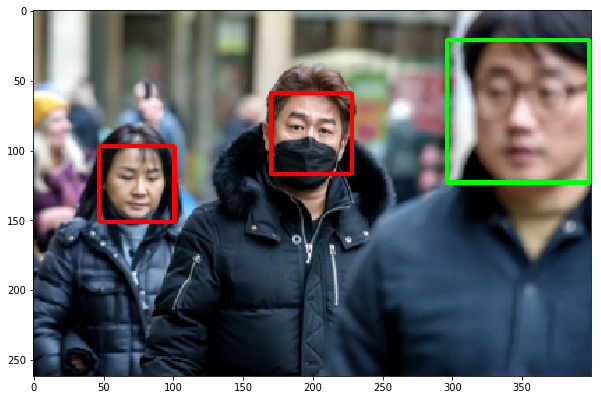

In [4]:
MIN_DISTANCE = 130

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

# Using mobilenet_v2 for mask detection

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Augmentation

In [6]:
train_dir = 'Input/masks12k/Train'
test_dir = 'Input/masks12k/Test'
val_dir = 'Input/masks12k/Validation'

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=25)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=25)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=25)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Transfer Learning

In [7]:
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(128,128,3))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 40962     
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [9]:
history = model.fit_generator(generator=train_generator,steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,validation_steps=len(val_generator)//32)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
12/12 [==============================] - 4s 368ms/step - loss: 0.2791 - accuracy: 0.9133 - val_loss: 0.4118 - val_accuracy: 0.9600
Epoch 2/20
12/12 [==============================] - 3s 282ms/step - loss: 0.1140 - accuracy: 0.9733 - val_loss: 0.0995 - val_accuracy: 0.9600
Epoch 3/20
12/12 [==============================] - 4s 294ms/step - loss: 0.1052 - accuracy: 0.9733 - val_loss: 0.6455 - val_accuracy: 0.9600
Epoch 4/20
12/12 [==============================] - 3s 284ms/step - loss: 0.0798 - accuracy: 0.9800 - val_loss: 1.6923e-04 - val_accuracy: 1.0000
Epoch 5/20
12/12 [==============================] - 4s 305ms/step - loss: 0.0734 - accuracy: 0.9800 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 3s 290ms/step - loss: 0.0520 - accuracy: 0.9833 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 4s 300ms/step - 

### Saving Model

In [10]:
# model.save('masknet.h5')

# Integrating with haar cascade

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

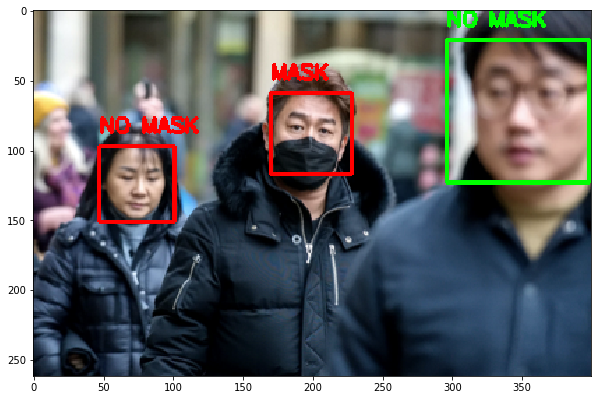

In [11]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")